## This Notebook contains the code to Forecast the weekly sales at a Department-Store Level for all 99 departments belonging to 45 stores. 
This is achieved  by training Gated Recurrent Unit (GRU), Long Short Term Memory (LSTM) & Backpropagation Through Time Recurrent Neural Network (BPTT RNN) models. The methods used and their corresponding results have been discussed below.

In [1]:
from __future__ import print_function
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
##from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

*Reading Dept-Store level data*

In [2]:
dept_store_lvl_df = pd.read_csv('data/sales_forecasting.csv')

In [3]:
dept_store_lvl_df.head()

,Store,Dept,Date,Weekly_Sales,Size,Type_A,Type_B,Type_C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,1,2/5/2010,24924.50,151315,1,0,0,42.31,2.572,211.096358,8.106,0
1,1,1,2/12/2010,46039.49,151315,1,0,0,38.51,2.548,211.242170,8.106,1
2,1,1,2/19/2010,41595.55,151315,1,0,0,39.93,2.514,211.289143,8.106,0
3,1,1,2/26/2010,19403.54,151315,1,0,0,46.63,2.561,211.319643,8.106,0
4,1,1,3/5/2010,21827.90,151315,1,0,0,46.50,2.625,211.350143,8.106,0


In [4]:
dept_store_lvl_df.shape

(421570, 13)

#### Creating week_nbr column

In [5]:
dept_store_lvl_df['Date'] = pd.to_datetime(dept_store_lvl_df.Date)
dept_store_lvl_df['week_nbr'] = dept_store_lvl_df.sort_values(['Date'],ascending=[True]).groupby(['Store', 'Dept'])\
             .cumcount() + 1
print(dept_store_lvl_df.head())
print(dept_store_lvl_df.shape)

   Store  Dept       Date  Weekly_Sales    Size  Type_A  Type_B  Type_C  \
0      1     1 2010-02-05      24924.50  151315       1       0       0   
1      1     1 2010-02-12      46039.49  151315       1       0       0   
2      1     1 2010-02-19      41595.55  151315       1       0       0   
3      1     1 2010-02-26      19403.54  151315       1       0       0   
4      1     1 2010-03-05      21827.90  151315       1       0       0   

   Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  week_nbr  
0        42.31       2.572  211.096358         8.106          0         1  
1        38.51       2.548  211.242170         8.106          1         2  
2        39.93       2.514  211.289143         8.106          0         3  
3        46.63       2.561  211.319643         8.106          0         4  
4        46.50       2.625  211.350143         8.106          0         5  
(421570, 14)


*Creating a periodic week_nbr column to capture week of the year value between 1 & 52. This column can capture the seasonality by holding the week of the year value*

In [6]:
a = []
for el in dept_store_lvl_df.week_nbr:
    if el>52 and el<=104:
        a.append(el-52)
    elif el>104:
        a.append(el-104)
    else:
        a.append(el)
week_nbr_periodic = pd.Series(a)
cols = list(dept_store_lvl_df.columns)
cols.append('week_nbr_periodic')
dept_store_lvl_df = pd.concat([dept_store_lvl_df, week_nbr_periodic], axis = 1)
dept_store_lvl_df.columns = cols

In [7]:
### Vary from Weeks 1 to 52 & repeat
print(dept_store_lvl_df.columns)
print(dept_store_lvl_df.week_nbr_periodic.unique())

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Size', 'Type_A', 'Type_B',
       'Type_C', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday', 'week_nbr', 'week_nbr_periodic'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]


In [8]:
print(dept_store_lvl_df.shape)
dept_store_lvl_df.head()

(421570, 15)


,Store,Dept,Date,Weekly_Sales,Size,Type_A,Type_B,Type_C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,week_nbr_periodic
0,1,1,2010-02-05,24924.50,151315,1,0,0,42.31,2.572,211.096358,8.106,0,1,1
1,1,1,2010-02-12,46039.49,151315,1,0,0,38.51,2.548,211.242170,8.106,1,2,2
2,1,1,2010-02-19,41595.55,151315,1,0,0,39.93,2.514,211.289143,8.106,0,3,3
3,1,1,2010-02-26,19403.54,151315,1,0,0,46.63,2.561,211.319643,8.106,0,4,4
4,1,1,2010-03-05,21827.90,151315,1,0,0,46.50,2.625,211.350143,8.106,0,5,5


#### Creating a single unified Store Level weekly sales dataset with 10 lagged moving window for every store
Sliding window sequences are created seperately for every store as the lags for every store have to be provided in isolation. Because we don't want to feed in the past values of one store as inputs to another store

*Identifying the distinctinctive break point between train & test for splitting.*
Because the data of a given store-dept should not be present in both Train & Test

In [18]:
for i,el in enumerate(range(295009,296000,143)):
    print(i,el)
    print(dept_store_lvl_df.iloc[el,:2])

0 295009
Store    31
Dept     10
Name: 295009, dtype: object
1 295152
Store    31
Dept     11
Name: 295152, dtype: object
2 295295
Store    31
Dept     12
Name: 295295, dtype: object
3 295438
Store    31
Dept     13
Name: 295438, dtype: object
4 295581
Store    31
Dept     14
Name: 295581, dtype: object
5 295724
Store    31
Dept     16
Name: 295724, dtype: object
6 295867
Store    31
Dept     17
Name: 295867, dtype: object


#### Preprocessing the data to create Train & Test Datasets by carrying out the following steps
 - Scaling the Data using MinMaxScaler, 
 - creating moving window sliders of sequence length 10 for every store-dept at a time so as to avoid leaking past data from one dept to another dept
 - Concatenating all the 3D Numpy Arrays to create one Train & Test dataset which is used to create train test loaders.
##### Note:
*Splitting after 295867 rows, i.e. after Store 31-Dept 17 as identified above.*
*This data_prep function is being used to create a 3 dimensional numpy array where the 3 dimensions are [batch_size(no of observations per batch) x sequence length of each attribute x number of attributes].*

In [21]:
### FUNCTION TO CREATE 'X' & 'Y' ARRAYs of the required sequence length. 
### x_arr will be a 3D Numpy object
def data_prep(xdata_arr,ydata_arr, input_seq_len):
    x_arr = []
    y_arr = []
    for i in range(len(xdata_arr)-input_seq_len):
        x_arr.append(xdata_arr[i:i+input_seq_len])
        y_arr.append(ydata_arr[i+input_seq_len])
    return np.array(x_arr), np.array(y_arr)

In [48]:
%%capture
stores_dict_ips = {}
stores_dict_tgt3 = {}
stores_dict_df3 = {}
stores_dict3 = {}   ### Creating a dictionary containing the 45 stores

store_train_x = dept_store_lvl_df.iloc[:295867,].drop(columns=['Date','Store','Dept','week_nbr'])
store_train_y = dept_store_lvl_df.iloc[:295867,]['Weekly_Sales'].to_frame()
store_test_x = dept_store_lvl_df.iloc[295867:,].drop(columns=['Date','Store','Dept','week_nbr'])
store_test_y = dept_store_lvl_df.iloc[295867:,]['Weekly_Sales'].to_frame()

#### Applying Scaler on entire Store Level Aggregated dataset
scaler = MinMaxScaler()
scaler = scaler.fit(store_train_x)
train_arr_x = scaler.transform(store_train_x)
test_arr_x = scaler.transform(store_test_x)
    
scaler = scaler.fit(store_train_y)
train_arr_y = scaler.transform(store_train_y)
test_arr_y = scaler.transform(store_test_y)

#### Creating Sliding Windows for Store 1 Dept 1
x_train, y_train = data_prep(train_arr_x[0:143],train_arr_y[0:143],10)
x_test, y_test = data_prep(test_arr_x[0:143],test_arr_y[0:143],10)

### Creating Sliding windows for other stores 2 to 45 and concatenating them into a single numpy array
for i in range(143,len(train_arr_x),143):   
    ### Calling Data Prep Function to create multivariate sequences (10 lag moving window) Processed
    x_train_store, y_train_store = data_prep(train_arr_x[i:i+143],train_arr_y[i:i+143],10)
    x_train = np.concatenate((x_train, x_train_store), axis=0)
    y_train = np.concatenate((y_train, y_train_store), axis=0)
    
for j in range(143,116907,143):  
    x_test_store, y_test_store = data_prep(test_arr_x[j:j+143],test_arr_y[j:j+143],10)
    x_test = np.concatenate((x_test, x_test_store), axis=0)
    y_test = np.concatenate((y_test, y_test_store), axis=0)
    
### Creating Train & Test Loader Objects
train_target3 = torch.tensor(y_train.astype(np.float32))
train3 = torch.tensor(x_train.astype(np.float32)) 
train_tensor3 = torch.utils.data.TensorDataset(train3, train_target3) 
train_loader3 = torch.utils.data.DataLoader(dataset = train_tensor3, batch_size = 143, shuffle = False)
train_loader_full = torch.utils.data.DataLoader(dataset = train_tensor3, batch_size = len(train3), shuffle = False)

test_target3 = torch.tensor(y_test.astype(np.float32))
test3 = torch.tensor(x_test.astype(np.float32)) 
test_tensor3 = torch.utils.data.TensorDataset(test3, test_target3) 
test_loader3 = torch.utils.data.DataLoader(dataset = test_tensor3, batch_size = len(test3),shuffle = False)  

In [49]:
print(len(y_train))
print(y_train.shape)
print(len(x_train))
print(x_train.shape)

print(len(y_test))
print(y_test.shape)
print(len(x_test))
print(x_test.shape)

275177
(275177, 1)
275177
(275177, 10, 11)
108794
(108794, 1)
108794
(108794, 10, 11)


#### Here, the train object has 143 rows per batch, 11 predictor attributes and sequence of length 10 per attribute (10 past values)
*Assigned every department to a Batch*

In [50]:
print(train3.shape)
print(train_target3.shape)
print(train_loader3.batch_size)
print(train_loader_full.batch_size)

print(test3.shape)
print(test_target3.shape)
print(test_loader3.batch_size)

torch.Size([275177, 10, 11])
torch.Size([275177, 1])
143
275177
torch.Size([108794, 10, 11])
torch.Size([108794, 1])
108794


### 1. GRU Network
Using a GRU layer and one hidden state with dimensions of number of layers, batch size and number of nodes (hidden dim)

In [44]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers,seq_len):
        super(GRU_Model, self).__init__()

        # Defining some parameters
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.seq_len = seq_len
        

        #Defining the layers
        # GRU Layer
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_dim,num_layers = n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)
    
    
    #def reset_hidden(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
    #    self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.hidden_dim),
    #                  torch.zeros(self.n_layers, self.seq_len, self.hidden_dim))
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        #out, _ = self.lstm(x.view(len(x),self.seq_len,self.input_size), hidden)
        out, _ = self.gru(x, hidden)
        #out_final = self.fc(out.view(self.seq_len,len(x),self.hidden_dim)[-1])
        out_final = self.fc(out[:,-1,:])
        return out_final
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

In [46]:
### FUNCTION to calculate TEST MSE after every epoch
def test_mse_rnn(model,test_loader):
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs,targets in test_loader:
            output = model(inputs)
            loss = criterion(output, targets)
    return loss.item()

### A. TRAINING a 1 layer GRU network model

In [56]:
input_size = 11
hidden_dim = 10
n_layers = 1      ### 1 LAYER
seq_len = 10

mse_train3 = []
mse_test3 = []
Y_pred_train_lst3 = []
Y_pred_test_lst3 = []

model_gru = GRU_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt
model_gru = model_gru.float()

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_gru.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 8

train_MSE_aft_weight_upd_gru3 = []
test_MSE_aft_weight_upd_gru3 = []

### Training on the dataset.
for e in range(epochs):
    for inputs,targets in train_loader3:    
           # Training pass
        output = model_gru(inputs.float())   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd_gru3.append(loss.item())        
        #test_MSE_aft_weight_upd_gru3.append(test_mse_rnn(model_gru,test_loader3))
        
with torch.no_grad():
    for inputs_train,targets_train in train_loader_full:
        Y_pred_train = model_gru(inputs_train.float())  ### Week level Predicted Sales for each store's train data
        mse_train3.append(criterion(Y_pred_train, targets_train))  ## MSE for a store's train data
        
with torch.no_grad():    
    for inputs_test,targets_test in test_loader3:
        Y_pred_test = model_gru(inputs_test.float())  ### Weekly Predicted Sales for each store's test data
        mse_test3.append(criterion(Y_pred_test, targets_test))  ## MSE for a store's test data

### Append Weekly Predictions into a list
Y_pred_train_lst3.append([el[0] for el in Y_pred_train.tolist()])
Y_pred_test_lst3.append([el[0] for el in Y_pred_test.tolist()])

#### Identified 8 Epochs with 16,000 weight updates as the optimum number of epochs required for the model to converge.
*Since there are 2000 batches in the train dataloader, 8 epochs have resulted in 16,000 weight updates*

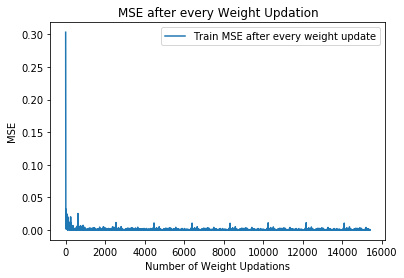

In [57]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(math.ceil(len(train3)/143)*epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd_gru3)
#ax1.plot(weight_updates, test_MSE_aft_weight_upd_gru3)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

#### TRAIN & TEST MSE using method A (1 layer GRU network)

In [58]:
print(mse_train3)
print(mse_test3)

[tensor(0.0001)]
[tensor(0.0001)]


#### Plotting Actual Vs Predicted Sales using 1 layer GRU network model, on the following Store Departments
- "Store 1-Department 1"
- "Store 1-Department 2"
- "Store 31-Department 17"
- "Store 31-Department 18"
- "Store 31-Department 19"
- "Store 31-Department 20"
- "Store 31-Department 21"
- "Store 31-Department 22"

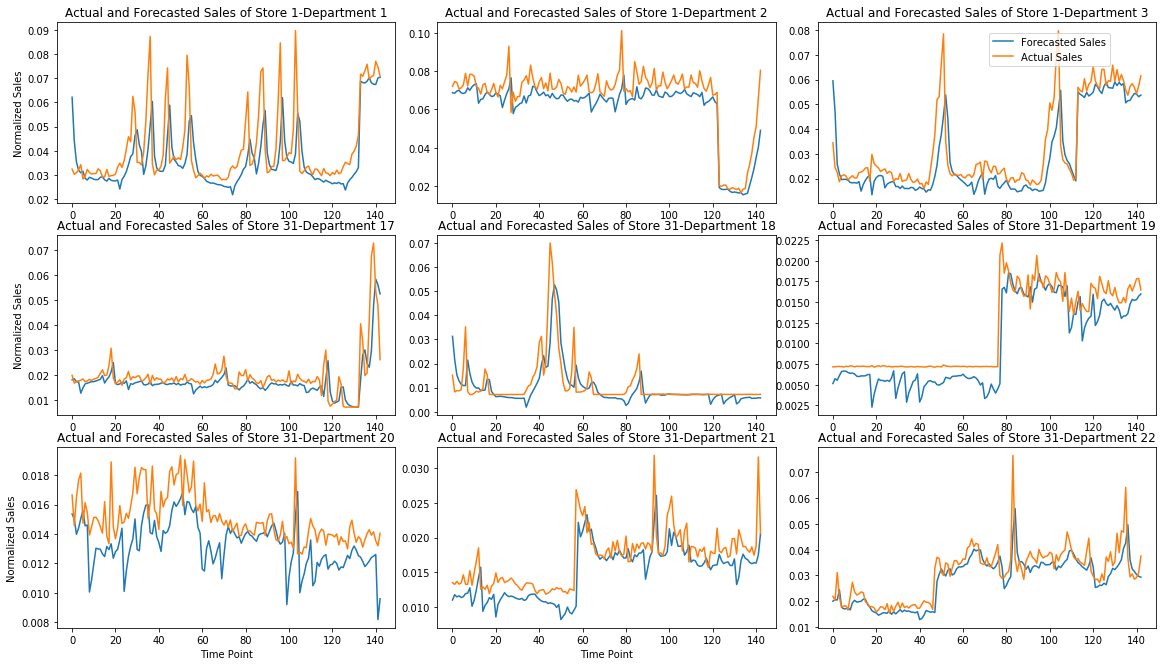

In [67]:
time_point_train = [el for el in range(0,143)]

plt.rcParams["figure.figsize"] = [16,9]
fig, axs = plt.subplots(3, 3)
fig.tight_layout()

### Store 1-Department 1 
axs[0, 0].plot(time_point_train, Y_pred_train_lst3[0][:143])
axs[0, 0].plot(time_point_train, [el[0] for el in y_train][:143])
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 1-Department 1')
axs[0, 0].set_ylabel('Normalized Sales')


### Store 1-Department 2 
axs[0, 1].plot(time_point_train, Y_pred_train_lst3[0][143:286])
axs[0, 1].plot(time_point_train, [el[0] for el in y_train][143:286])
axs[0, 1].set_title('Actual and Forecasted Sales of Store 1-Department 2')


###Store 1-Department 3 
axs[0, 2].plot(time_point_train, Y_pred_train_lst3[0][2*143:3*143])
axs[0, 2].plot(time_point_train, [el[0] for el in y_train][2*143:3*143])
axs[0, 2].set_title('Actual and Forecasted Sales of Store 1-Department 3')


### STORE Store 31-Department 17
axs[1, 0].plot(time_point_train, Y_pred_test_lst3[0][0:143])
axs[1, 0].plot(time_point_train, [el[0] for el in y_test][0:143])
axs[1, 0].set_title('Actual and Forecasted Sales of Store 31-Department 17')
axs[1, 0].set_ylabel('Normalized Sales')
#axs[1, 0].set_xlabel('Time Point')

### STORE Store 31-Department 18
axs[1, 1].plot(time_point_train, Y_pred_test_lst3[0][143:286])
axs[1, 1].plot(time_point_train, [el[0] for el in y_test][143:286])
axs[1, 1].set_title('Actual and Forecasted Sales of Store 31-Department 18')
#axs[1, 1].set_xlabel('Time Point')

### STORE Store 31-Department 19
axs[1, 2].plot(time_point_train, Y_pred_test_lst3[0][2*143:3*143])
axs[1, 2].plot(time_point_train, [el[0] for el in y_test][2*143:3*143])
axs[1, 2].set_title('Actual and Forecasted Sales of Store 31-Department 19')
#axs[1, 1].set_xlabel('Time Point')


### STORE Store 31-Department 20
axs[2, 0].plot(time_point_train, Y_pred_test_lst3[0][3*143:4*143])
axs[2, 0].plot(time_point_train, [el[0] for el in y_test][3*143:4*143])
axs[2, 0].set_title('Actual and Forecasted Sales of Store 31-Department 20')
axs[2, 0].set_ylabel('Normalized Sales')
axs[2, 0].set_xlabel('Time Point')

### STORE Store 31-Department 21
axs[2, 1].plot(time_point_train, Y_pred_test_lst3[0][4*143:5*143])
axs[2, 1].plot(time_point_train, [el[0] for el in y_test][4*143:5*143])
axs[2, 1].set_title('Actual and Forecasted Sales of Store 31-Department 21')
axs[2, 1].set_xlabel('Time Point')

### STORE Store 31-Department 22
axs[2, 2].plot(time_point_train, Y_pred_test_lst3[0][5*143:6*143])
axs[2, 2].plot(time_point_train, [el[0] for el in y_test][5*143:6*143])
axs[2, 2].set_title('Actual and Forecasted Sales of Store 31-Department 22')
axs[2, 1].set_xlabel('Time Point')

plt.show()

### B. TRAINING a 2 layer GRU network model to compare and contrast the performance

In [92]:
input_size = 11
hidden_dim = 10
n_layers = 2    ### 2 LAYERS
seq_len = 10

mse_train4 = []
mse_test4 = []
Y_pred_train_lst4 = []
Y_pred_test_lst4 = []

model_gru = GRU_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt
model_gru = model_gru.float()

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_gru.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 35

train_MSE_aft_weight_upd_gru4 = []
test_MSE_aft_weight_upd_gru4 = []

### Training on the dataset.
for e in range(epochs):
    for inputs,targets in train_loader3:    
           # Training pass
        output = model_gru(inputs.float())   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd_gru4.append(loss.item())        
        #test_MSE_aft_weight_upd_gru3.append(test_mse_rnn(model_gru,test_loader3))
        
with torch.no_grad():
    for inputs_train,targets_train in train_loader_full:
        Y_pred_train = model_gru(inputs_train.float())  ### Week level Predicted Sales for each store's train data
        mse_train4.append(criterion(Y_pred_train, targets_train))  ## MSE for a store's train data
        
with torch.no_grad():    
    for inputs_test,targets_test in test_loader3:
        Y_pred_test = model_gru(inputs_test.float())  ### Weekly Predicted Sales for each store's test data
        mse_test4.append(criterion(Y_pred_test, targets_test))  ## MSE for a store's test data

### Append Weekly Predictions into a list
Y_pred_train_lst4.append([el[0] for el in Y_pred_train.tolist()])
Y_pred_test_lst4.append([el[0] for el in Y_pred_test.tolist()])

#### Identified 35 Epochs with 70,000 weight updates as the optimum number of epochs required for the model to converge

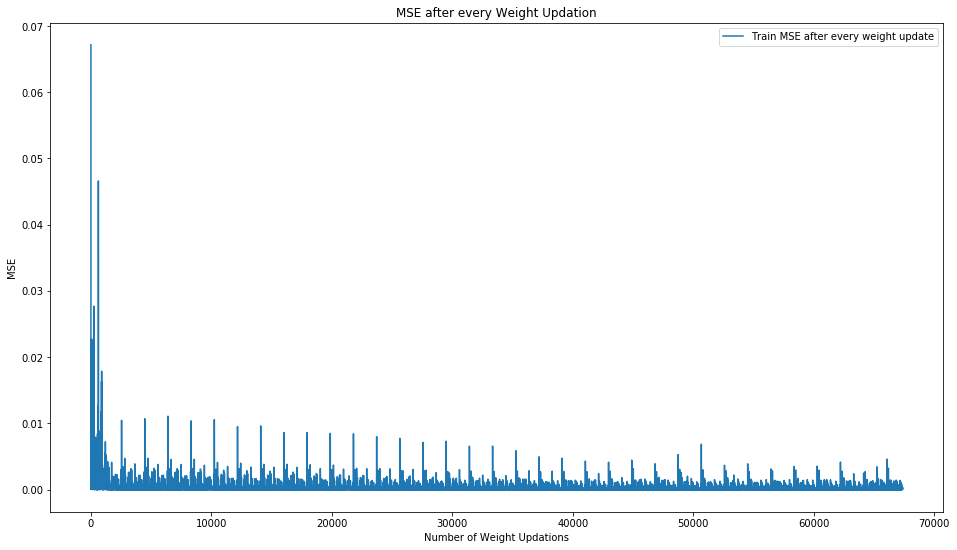

In [93]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(math.ceil(len(train3)/143)*epochs)]

fig = plt.figure()
#ax1 = fig.add_subplot(111)
plt.plot(weight_updates, train_MSE_aft_weight_upd_gru4)
#ax1.plot(weight_updates, test_MSE_aft_weight_upd_gru3)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

#### Train & Test MSE for Approach B (2 layer GRU network)

In [94]:
print(mse_train4)
print(mse_test4)

[tensor(0.0003)]
[tensor(0.0002)]


#### Plotting Actual Vs Predicted Sales using 2 layer GRU network model, on the following Store Departments
- "Store 1-Department 1"
- "Store 1-Department 2"
- "Store 31-Department 17"
- "Store 31-Department 18"
- "Store 31-Department 19"
- "Store 31-Department 20"
- "Store 31-Department 21"
- "Store 31-Department 22"

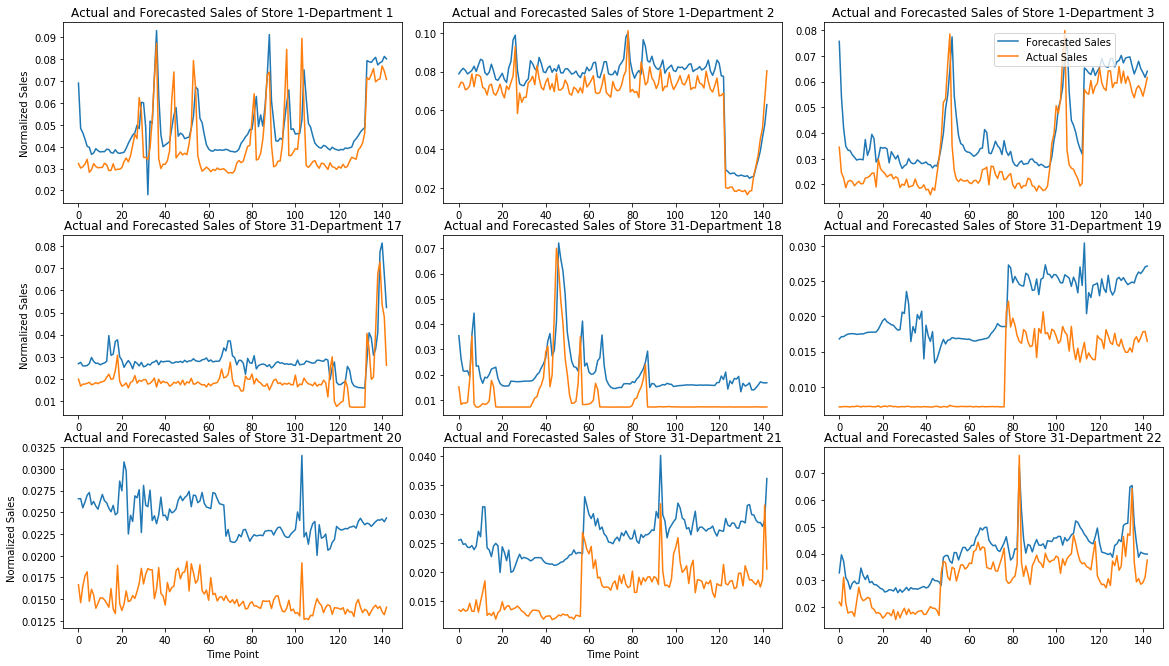

In [95]:
time_point_train = [el for el in range(0,143)]

plt.rcParams["figure.figsize"] = [16,9]
fig, axs = plt.subplots(3, 3)
fig.tight_layout()

### Store 1-Department 1 
axs[0, 0].plot(time_point_train, Y_pred_train_lst4[0][:143])
axs[0, 0].plot(time_point_train, [el[0] for el in y_train][:143])
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 1-Department 1')
axs[0, 0].set_ylabel('Normalized Sales')


### Store 1-Department 2 
axs[0, 1].plot(time_point_train, Y_pred_train_lst4[0][143:286])
axs[0, 1].plot(time_point_train, [el[0] for el in y_train][143:286])
axs[0, 1].set_title('Actual and Forecasted Sales of Store 1-Department 2')


###Store 1-Department 3 
axs[0, 2].plot(time_point_train, Y_pred_train_lst4[0][2*143:3*143])
axs[0, 2].plot(time_point_train, [el[0] for el in y_train][2*143:3*143])
axs[0, 2].set_title('Actual and Forecasted Sales of Store 1-Department 3')


### STORE Store 31-Department 17
axs[1, 0].plot(time_point_train, Y_pred_test_lst4[0][0:143])
axs[1, 0].plot(time_point_train, [el[0] for el in y_test][0:143])
axs[1, 0].set_title('Actual and Forecasted Sales of Store 31-Department 17')
axs[1, 0].set_ylabel('Normalized Sales')
#axs[1, 0].set_xlabel('Time Point')

### STORE Store 31-Department 18
axs[1, 1].plot(time_point_train, Y_pred_test_lst4[0][143:286])
axs[1, 1].plot(time_point_train, [el[0] for el in y_test][143:286])
axs[1, 1].set_title('Actual and Forecasted Sales of Store 31-Department 18')
#axs[1, 1].set_xlabel('Time Point')

### STORE Store 31-Department 19
axs[1, 2].plot(time_point_train, Y_pred_test_lst4[0][2*143:3*143])
axs[1, 2].plot(time_point_train, [el[0] for el in y_test][2*143:3*143])
axs[1, 2].set_title('Actual and Forecasted Sales of Store 31-Department 19')
#axs[1, 1].set_xlabel('Time Point')


### STORE Store 31-Department 20
axs[2, 0].plot(time_point_train, Y_pred_test_lst4[0][3*143:4*143])
axs[2, 0].plot(time_point_train, [el[0] for el in y_test][3*143:4*143])
axs[2, 0].set_title('Actual and Forecasted Sales of Store 31-Department 20')
axs[2, 0].set_ylabel('Normalized Sales')
axs[2, 0].set_xlabel('Time Point')

### STORE Store 31-Department 21
axs[2, 1].plot(time_point_train, Y_pred_test_lst4[0][4*143:5*143])
axs[2, 1].plot(time_point_train, [el[0] for el in y_test][4*143:5*143])
axs[2, 1].set_title('Actual and Forecasted Sales of Store 31-Department 21')
axs[2, 1].set_xlabel('Time Point')

### STORE Store 31-Department 22
axs[2, 2].plot(time_point_train, Y_pred_test_lst4[0][5*143:6*143])
axs[2, 2].plot(time_point_train, [el[0] for el in y_test][5*143:6*143])
axs[2, 2].set_title('Actual and Forecasted Sales of Store 31-Department 22')
axs[2, 1].set_xlabel('Time Point')

plt.show()

#### There is not a significant difference in train & test MSEs for GRU models with 2 layers and 1 layer as seen in the above graphs and MSE results. Hence we will not be further experimenting by adding additional layers. Instead, we will try LSTMs and RNNs with BPTT.

## Next Steps:

### 2. LSTMs 

### 3. RNN with BPTT